# ORF recognition by Convolutional/Recurrent

Start with ORF_CNN_118 and add an LSTM layer.

In [12]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-17 18:32:29 UTC'

In [13]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=100            # how long is each sequence
CDS_LEN=60            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [14]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [15]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [16]:
import random
def partition_random_sequences(goal_per_class):
    pc_seqs=[]
    nc_seqs=[]
    oc = ORF_counter()
    trials = 0
    pc_cnt = 0
    nc_cnt = 0
    bases=['A','C','G','T']
    while pc_cnt<goal_per_class or nc_cnt<goal_per_class:
        trials += 1        
        between_bases = random.randint(0,RNA_LEN-6) 
        utr5_bases = (RNA_LEN - (between_bases + 6)) // 2
        utr3_bases = RNA_LEN - (utr5_bases + (between_bases+6))
        one_seq  = "".join(random.choices(bases,k=utr5_bases)) 
        one_seq += 'ATG'    
        one_seq += "".join(random.choices(bases,k=between_bases)) 
        random_stop = random.choice(['TAA','TAG','TGA']) # random frame
        one_seq += random_stop
        one_seq += "".join(random.choices(bases,k=utr3_bases))  
        if len(one_seq) != RNA_LEN:
            print("WRONG LENGTH:",len(one_seq),utr5_bases,between_bases,utr3_bases)
        oc.set_sequence(one_seq)
        cds_len = oc.get_max_cds_len() + 3
        if cds_len >= CDS_LEN and pc_cnt<goal_per_class:
            pc_cnt += 1
            pc_seqs.append(one_seq)
        elif cds_len < CDS_LEN and nc_cnt<goal_per_class:
            nc_cnt += 1
            nc_seqs.append(one_seq)
    print ("It took %d trials to reach %d per class."%(trials,goal_per_class))
    return pc_seqs,nc_seqs
pc_all,nc_all=partition_random_sequences(10)  # just testing
pc_all,nc_all=partition_random_sequences(PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 48 trials to reach 10 per class.
It took 158005 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [17]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 100.0
Average ORF length: 67.63409090909092
NC seqs
Average RNA length: 100.0
Average ORF length: 22.246545454545455


In [18]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [19]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [20]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (100, 4)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 100, 16)           208       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 100, 16)           784       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 16)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 16)            2112      
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)    

In [21]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 16s 10ms/step - loss: 0.7013 - accuracy: 0.5285 - val_loss: 0.6591 - val_accuracy: 0.6055


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6479 - accuracy: 0.6279 - val_loss: 0.6275 - val_accuracy: 0.6438


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6176 - accuracy: 0.6584 - val_loss: 0.6069 - val_accuracy: 0.6643


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6004 - accuracy: 0.6761 - val_loss: 0.5721 - val_accuracy: 0.6919


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5757 - accuracy: 0.6954 - val_loss: 0.5671 - val_accuracy: 0.6973


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5642 - accuracy: 0.6993 - val_loss: 0.5416 - val_accuracy: 0.7087


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5462 - accuracy: 0.7098 - val_loss: 0.5331 - val_accuracy: 0.7147


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5395 - accuracy: 0.7135 - val_loss: 0.5417 - val_accuracy: 0.7067
Epoch 9/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5395 - accuracy: 0.7123 - val_loss: 0.5263 - val_accuracy: 0.7171


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5342 - accuracy: 0.7175 - val_loss: 0.5290 - val_accuracy: 0.7137
Epoch 11/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5355 - accuracy: 0.7136 - val_loss: 0.5269 - val_accuracy: 0.7153
Epoch 12/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5298 - accuracy: 0.7208 - val_loss: 0.5505 - val_accuracy: 0.7048
Epoch 13/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5348 - accuracy: 0.7163 - val_loss: 0.5228 - val_accuracy: 0.7181


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5294 - accuracy: 0.7173 - val_loss: 0.5259 - val_accuracy: 0.7147
Epoch 15/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5288 - accuracy: 0.7154 - val_loss: 0.5252 - val_accuracy: 0.7172
Epoch 16/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5265 - accuracy: 0.7202 - val_loss: 0.5899 - val_accuracy: 0.6752
Epoch 17/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5406 - accuracy: 0.7135 - val_loss: 0.5465 - val_accuracy: 0.6962
Epoch 18/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5243 - accuracy: 0.7189 - val_loss: 0.5203 - val_accuracy: 0.7186


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5190 - accuracy: 0.7225 - val_loss: 0.5303 - val_accuracy: 0.7167
Epoch 20/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5282 - accuracy: 0.7193 - val_loss: 0.5195 - val_accuracy: 0.7174
Epoch 21/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5289 - accuracy: 0.7205 - val_loss: 0.5336 - val_accuracy: 0.7124
Epoch 22/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5205 - accuracy: 0.7246 - val_loss: 0.5193 - val_accuracy: 0.7152
Epoch 23/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5210 - accuracy: 0.7243 - val_loss: 0.5172 - val_accuracy: 0.7210


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5164 - accuracy: 0.7250 - val_loss: 0.5187 - val_accuracy: 0.7186
Epoch 25/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5303 - accuracy: 0.7180 - val_loss: 0.5232 - val_accuracy: 0.7173
Epoch 26/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5220 - accuracy: 0.7217 - val_loss: 0.5293 - val_accuracy: 0.7188
Epoch 27/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5149 - accuracy: 0.7258 - val_loss: 0.5205 - val_accuracy: 0.7175
Epoch 28/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5207 - accuracy: 0.7223 - val_loss: 0.5187 - val_accuracy: 0.7171
Epoch 29/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5102 - accuracy: 0.7308 - val_loss: 0.5135 - val_accuracy: 0.7197
Epoch 30/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5096 - accuracy: 0.7278 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5122 - accuracy: 0.7260 - val_loss: 0.5176 - val_accuracy: 0.7204
Epoch 33/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5124 - accuracy: 0.7278 - val_loss: 0.5179 - val_accuracy: 0.7159
Epoch 34/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5359 - accuracy: 0.7221 - val_loss: 0.5216 - val_accuracy: 0.7193
Epoch 35/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5131 - accuracy: 0.7289 - val_loss: 0.5172 - val_accuracy: 0.7200
Epoch 36/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5076 - accuracy: 0.7304 - val_loss: 0.5239 - val_accuracy: 0.7214
Epoch 37/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5569 - accuracy: 0.6853 - val_loss: 0.6138 - val_accuracy: 0.6474
Epoch 38/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5978 - accuracy: 0.6769 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 45/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5213 - accuracy: 0.7204 - val_loss: 0.5161 - val_accuracy: 0.7199
Epoch 46/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5183 - accuracy: 0.7228 - val_loss: 0.5149 - val_accuracy: 0.7187
Epoch 47/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5185 - accuracy: 0.7240 - val_loss: 0.5128 - val_accuracy: 0.7210
Epoch 48/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5213 - accuracy: 0.7242 - val_loss: 0.5153 - val_accuracy: 0.7245


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 49/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5127 - accuracy: 0.7258 - val_loss: 0.5128 - val_accuracy: 0.7227
Epoch 50/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5176 - accuracy: 0.7224 - val_loss: 0.5138 - val_accuracy: 0.7232
Epoch 51/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5158 - accuracy: 0.7246 - val_loss: 0.5108 - val_accuracy: 0.7238
Epoch 52/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5128 - accuracy: 0.7263 - val_loss: 0.5104 - val_accuracy: 0.7258


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 53/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5082 - accuracy: 0.7293 - val_loss: 0.5147 - val_accuracy: 0.7200
Epoch 54/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5158 - accuracy: 0.7285 - val_loss: 0.5100 - val_accuracy: 0.7253
Epoch 55/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5095 - accuracy: 0.7286 - val_loss: 0.5141 - val_accuracy: 0.7232
Epoch 56/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5070 - accuracy: 0.7319 - val_loss: 0.5108 - val_accuracy: 0.7235
Epoch 57/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5115 - accuracy: 0.7277 - val_loss: 0.5126 - val_accuracy: 0.7244
Epoch 58/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5134 - accuracy: 0.7252 - val_loss: 0.5117 - val_accuracy: 0.7221
Epoch 59/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5084 - accuracy: 0.7303 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 63/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5048 - accuracy: 0.7310 - val_loss: 0.5157 - val_accuracy: 0.7260
Epoch 64/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5029 - accuracy: 0.7329 - val_loss: 0.5158 - val_accuracy: 0.7246
Epoch 65/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5029 - accuracy: 0.7318 - val_loss: 0.5362 - val_accuracy: 0.7055
Epoch 66/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5145 - accuracy: 0.7259 - val_loss: 0.5102 - val_accuracy: 0.7222
Epoch 67/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4983 - accuracy: 0.7343 - val_loss: 0.5127 - val_accuracy: 0.7251
Epoch 68/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5011 - accuracy: 0.7344 - val_loss: 0.5153 - val_accuracy: 0.7241
Epoch 69/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5010 - accuracy: 0.7342 - val_loss: 0

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 72/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4977 - accuracy: 0.7357 - val_loss: 0.5158 - val_accuracy: 0.7178
Epoch 73/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4986 - accuracy: 0.7405 - val_loss: 0.5101 - val_accuracy: 0.7228
Epoch 74/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4966 - accuracy: 0.7391 - val_loss: 0.5102 - val_accuracy: 0.7258
Epoch 75/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4953 - accuracy: 0.7394 - val_loss: 0.5707 - val_accuracy: 0.6947
Epoch 76/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5238 - accuracy: 0.7249 - val_loss: 0.5149 - val_accuracy: 0.7240
Epoch 77/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5030 - accuracy: 0.7287 - val_loss: 0.5139 - val_accuracy: 0.7234
Epoch 78/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5018 - accuracy: 0.7325 - val_loss: 0

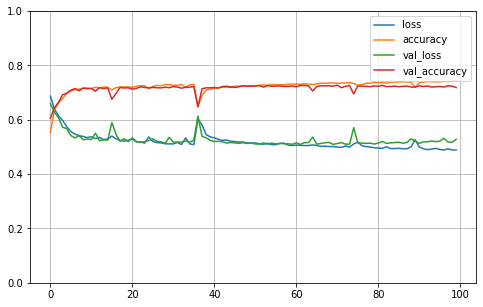

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 16s 10ms/step - loss: 0.7087 - accuracy: 0.5183 - val_loss: 0.6538 - val_accuracy: 0.6145
Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6410 - accuracy: 0.6342 - val_loss: 0.6202 - val_accuracy: 0.6557
Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6171 - accuracy: 0.6580 - val_loss: 0.5818 - val_accuracy: 0.6872
Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5797 - accuracy: 0.6920 - val_loss: 0.5481 - val_accuracy: 0.7063
Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5497 - accuracy: 0.7076 - val_loss: 0.5462 - val_accuracy: 0.7070
Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5401 - accuracy: 0.7106 - val_loss: 0.5345 - val_accuracy: 0.7126
Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.53

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5051 - accuracy: 0.7267 - val_loss: 0.5163 - val_accuracy: 0.7251
Epoch 32/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5027 - accuracy: 0.7309 - val_loss: 0.5176 - val_accuracy: 0.7256
Epoch 33/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5112 - accuracy: 0.7233 - val_loss: 0.5286 - val_accuracy: 0.7172
Epoch 34/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5062 - accuracy: 0.7314 - val_loss: 0.5153 - val_accuracy: 0.7252
Epoch 35/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5003 - accuracy: 0.7271 - val_loss: 0.5195 - val_accuracy: 0.7237
Epoch 36/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4996 - accuracy: 0.7289 - val_loss: 0.5233 - val_accuracy: 0.7221
Epoch 37/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.4991 - accuracy: 0.7315 - val_loss: 0

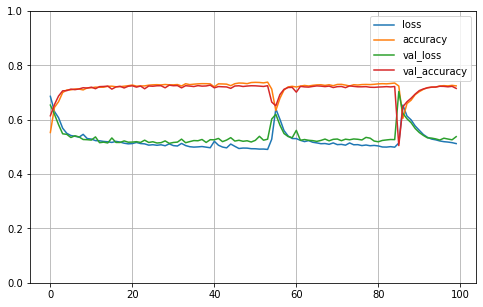

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 16s 10ms/step - loss: 0.6977 - accuracy: 0.5351 - val_loss: 0.6517 - val_accuracy: 0.6187
Epoch 2/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6443 - accuracy: 0.6301 - val_loss: 0.6099 - val_accuracy: 0.6670
Epoch 3/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.6104 - accuracy: 0.6706 - val_loss: 0.5755 - val_accuracy: 0.6972
Epoch 4/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5772 - accuracy: 0.6954 - val_loss: 0.5529 - val_accuracy: 0.7059
Epoch 5/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5561 - accuracy: 0.7083 - val_loss: 0.5599 - val_accuracy: 0.6967
Epoch 6/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.5437 - accuracy: 0.7115 - val_loss: 0.5512 - val_accuracy: 0.7053
Epoch 7/100
1334/1334 [==============================] - 12s 9ms/step - loss: 0.54

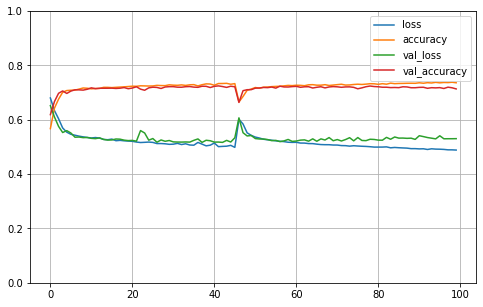

In [22]:
do_cross_validation(X,y)

In [23]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 72.95%


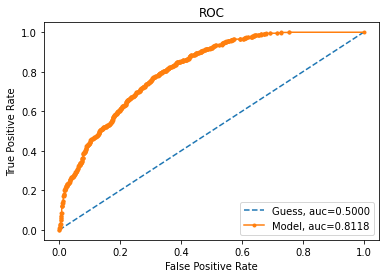

AUC: 81.18%


In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [25]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-17 19:37:41 UTC'